# Zillow Regression Project

### Imports

In [1]:
from env import host, user, password
import acquire
import prepare
import wrangle

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score

<hr style="border:3px solid black"> </hr>

# Acquire

In [4]:
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [5]:
def get_zillow():
    '''
    This function reads in the Zillow data from the Codeup db
    with properties_2017, predictions_2017 and propertylandusetype tables joined
    returns: a pandas DataFrame 
    '''
    
    zp_query = '''
    SELECT calculatedfinishedsquarefeet, bedroomcnt, bathroomcnt, taxvaluedollarcnt, taxamount, yearbuilt, fips, properties_2017.parcelid
    FROM properties_2017
    JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
    JOIN propertylandusetype ON properties_2017.propertylandusetypeid= propertylandusetype.propertylandusetypeid
    WHERE predictions_2017.transactiondate BETWEEN '2017-05-01' AND '2017-08-31' AND properties_2017.propertylandusetypeid IN (260, 261, 262, 263, 264, 265, 268, 273, 274, 275, 276, 279);
    '''
    return pd.read_sql(zp_query, get_connection('zillow'))

In [6]:
df= acquire.get_zillow()

In [7]:
#function saved to acquire that gets zillow info and saves as csv to make future work faster
def get_zillow_file():
    if os.path.isfile('zillow.csv'):
        df = pd.read_csv('zillow.csv', index_col=0)
    
    else:
        df = get_zillow()
        df.to_csv('zillow.csv')
    
    return df

In [8]:
df = acquire.get_zillow_file()

In [9]:
df.head()

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,yearbuilt,fips,parcelid
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0,11721753
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0,11289917
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0,11705026
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0,14269464
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0,11446756


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28418 entries, 0 to 28417
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  28345 non-null  float64
 1   bedroomcnt                    28418 non-null  float64
 2   bathroomcnt                   28418 non-null  float64
 3   taxvaluedollarcnt             28417 non-null  float64
 4   taxamount                     28417 non-null  float64
 5   yearbuilt                     28322 non-null  float64
 6   fips                          28418 non-null  float64
 7   parcelid                      28418 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 2.0 MB


### Takeaways from Acquire:
- based somewhat on personal interpretation, different "propertylandusetypeid" may be used. 
    - ended up settling on 12 ids
- creating a function to save get_zillow into a csv will drastically reduce time to import
- 28,418 entries
- 8 different columns
    - appear to have some nulls (further explore this in prepare
    - all numeric datatypes (float64 & int64)

<hr style="border:3px solid black"> </hr>

# Prepare

In [11]:
df.head()

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,yearbuilt,fips,parcelid
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0,11721753
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0,11289917
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0,11705026
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0,14269464
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0,11446756


In [12]:
#calculate tax rate
df['tax_rate'] =df['taxamount']/  df['taxvaluedollarcnt']

In [13]:
#rename columns to make more legible
df = df.rename(columns={"calculatedfinishedsquarefeet": "total_sqft", "bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "taxvaluedollarcnt": "value_assessed", "taxamount": "tax_amount", "yearbuilt": "year_built", "fips": "county_code" })

In [15]:
#check for duplicates
df.drop_duplicates(inplace=True)

In [16]:
#28,392 entries (removed 26 duplicates)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28392 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      28321 non-null  float64
 1   bedrooms        28392 non-null  float64
 2   bathrooms       28392 non-null  float64
 3   value_assessed  28391 non-null  float64
 4   tax_amount      28391 non-null  float64
 5   year_built      28298 non-null  float64
 6   county_code     28392 non-null  float64
 7   parcelid        28392 non-null  int64  
 8   tax_rate        28390 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


In [17]:
# replace nan values (resulting in no loss of entries)
df = df.replace(r'^\s*$', np.nan, regex=True)

In [18]:
#check for null values
df.isnull().sum()

total_sqft        71
bedrooms           0
bathrooms          0
value_assessed     1
tax_amount         1
year_built        94
county_code        0
parcelid           0
tax_rate           2
dtype: int64

In [19]:
#drop na values 
df = df.dropna()

In [20]:
#after dropping na- 28292 entries left (100 dropped)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28292 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      28292 non-null  float64
 1   bedrooms        28292 non-null  float64
 2   bathrooms       28292 non-null  float64
 3   value_assessed  28292 non-null  float64
 4   tax_amount      28292 non-null  float64
 5   year_built      28292 non-null  float64
 6   county_code     28292 non-null  float64
 7   parcelid        28292 non-null  int64  
 8   tax_rate        28292 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


In [21]:
#confirm all nulls were dropped
df.isnull().sum()

total_sqft        0
bedrooms          0
bathrooms         0
value_assessed    0
tax_amount        0
year_built        0
county_code       0
parcelid          0
tax_rate          0
dtype: int64

In [88]:
#see what correlates best with value_assessed
df.corr()

,total_sqft,bedrooms,bathrooms,value_assessed,tax_amount,year_built,county_code,parcelid,tax_rate
total_sqft,1.000000,0.600476,0.773866,0.452595,0.453914,0.483572,0.139422,0.080034,-0.066125
bedrooms,0.600476,1.000000,0.570725,0.203030,0.209334,0.352950,0.125782,0.078240,-0.034070
bathrooms,0.773866,0.570725,1.000000,0.372216,0.376115,0.552511,0.140218,0.081324,-0.059136
value_assessed,0.452595,0.203030,0.372216,1.000000,0.958867,0.226180,0.126221,0.081411,-0.207668
tax_amount,0.453914,0.209334,0.376115,0.958867,1.000000,0.245168,0.061734,0.042193,-0.083490
year_built,0.483572,0.352950,0.552511,0.226180,0.245168,1.000000,0.301400,0.177725,-0.025044
county_code,0.139422,0.125782,0.140218,0.126221,0.061734,0.301400,1.000000,0.543955,-0.113814
parcelid,0.080034,0.078240,0.081324,0.081411,0.042193,0.177725,0.543955,1.000000,-0.067862
tax_rate,-0.066125,-0.034070,-0.059136,-0.207668,-0.083490,-0.025044,-0.113814,-0.067862,1.000000


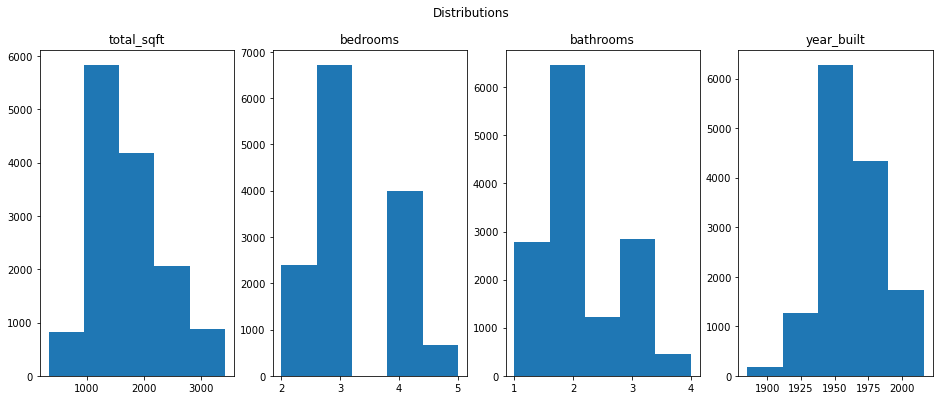

In [80]:
# Plot the distributions
plt.figure(figsize=(16, 6))

# List of columns
cols = ['total_sqft', 'bedrooms', 'bathrooms', 'year_built']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    train[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    plt.suptitle('Distributions')

<hr style="border:1px solid black"> </hr>

##### Dealing with Bedroom Outliers

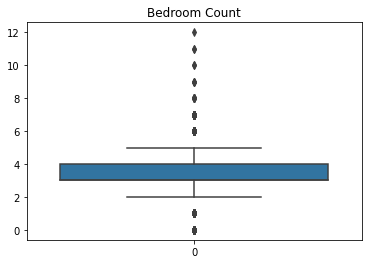

In [23]:
#visualize distribution and outliers
sns.boxplot(data=df.bedrooms)
plt.title('Distribution of Bedroom Count')
plt.show()

In [24]:
#descriptive statistics of bedrooms
df.bedrooms.describe()

count    28292.000000
mean         3.305988
std          0.936688
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: bedrooms, dtype: float64

In [29]:
#finding IQR of bedrooms to find outliers
q1_bed = df['bedrooms'].quantile(0.25)
q3_bed = df['bedrooms'].quantile(0.75)
iqr_bed = q3_bed - q1_bed
print(f'IQR for bedrooms is: {iqr_bed}')
print(f'Q3 for bedrooms is: {q3_bed}')
print(f'Q1 for bedrooms is: {q1_bed}')

IQR for bedrooms is: 1.0
Q3 for bedrooms is: 4.0
Q1 for bedrooms is: 3.0


In [26]:
#in order to find upper and lower bounds, must use following formula
lowerbound_bed = q1_bed - (1.5 * iqr_bed)
upperbound_bed = q3_bed + (1.5 * iqr_bed)
print(f'Lower bounds for bedroom count is: {lowerbound_bed}')
print(f'Upprt bounds for bedroom count is: {upperbound_bed}')

Lower bounds for bedroom count is: 1.5
Upprt bounds for bedroom count is: 5.5


In [30]:
#remove outliers for bedrooms
df= df[df.bedrooms > lowerbound_bed]
df= df[df.bedrooms < upperbound_bed]

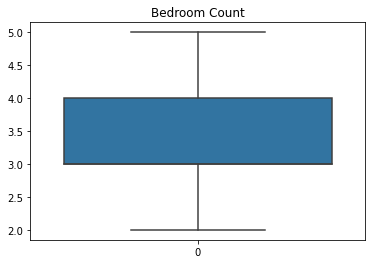

In [31]:
#show outliers have been removed
sns.boxplot(data=df.bedrooms)
plt.title('Distribution of Bedroom Count')
plt.show()

<hr style="border:1px solid black"> </hr>

##### Dealing with Bathroom Outliers

In [32]:
#descriptive stats for bathrooms, help understand outliers
df.bathrooms.describe()

count    27530.000000
mean         2.299491
std          0.950588
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: bathrooms, dtype: float64

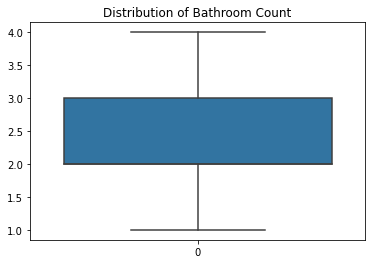

In [51]:
#visualize outliers
sns.boxplot(data=df.bathrooms)
plt.title('Distribution of Bathroom Count')
plt.show()

In [34]:
#finding IQR of bathrooms to find outliers
q1_bath = df['bathrooms'].quantile(0.25)
q3_bath = df['bathrooms'].quantile(0.75)
iqr_bath = q3_bath - q1_bath

print(f'IQR for bathrooms is: {iqr_bath}')
print(f'Q3 for bathrooms is: {q3_bath}')
print(f'Q1 for bathrooms is: {q1_bath}')

IQR for bathrooms is: 1.0
Q3 for bathrooms is: 3.0
Q1 for bathrooms is: 2.0


In [35]:
lowerbound_bath = q1_bath - (1.5 * iqr_bath)
upperbound_bath = q3_bath + (1.5 * iqr_bath)
lowerbound_bath, upperbound_bath
print(f'Lower bounds for bathroom count is: {lowerbound_bath}')
print(f'Upper bounds for bathroom count is: {upperbound_bath}')

Lower bounds for bathroom count is: 0.5
Upper bounds for bathroom count is: 4.5


In [36]:
#remove outliers for bathroom
df= df[df.bathrooms > lowerbound_bath]
df= df[df.bathrooms < upperbound_bath]

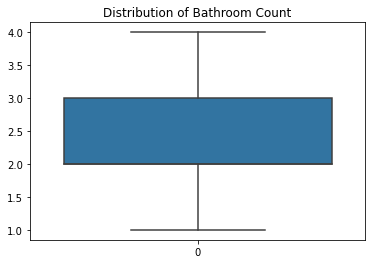

In [40]:
#show outliers have been removed
sns.boxplot(data=df.bathrooms)
plt.title('Distribution of Bathroom Count')
plt.show()

<hr style="border:1px solid black"> </hr>

##### Dealing with Value Appraised Outliers

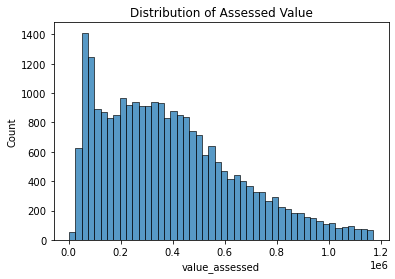

In [49]:
#taxvalue distribution
sns.histplot(data=df.value_assessed)
plt.title('Distribution of Assessed Value')
plt.show()

In [39]:
df.value_assessed.describe()

count    2.648000e+04
mean     4.618069e+05
std      4.628791e+05
min      1.000000e+03
25%      1.921658e+05
50%      3.654890e+05
75%      5.840095e+05
max      1.360010e+07
Name: value_assessed, dtype: float64

In [42]:
#finding IQR of Tax Value to find outliers
q1_tax = df['value_assessed'].quantile(0.25)
q3_tax = df['value_assessed'].quantile(0.75)
iqr_tax = q3_tax- q1_tax

print(f'IQR for value assessed is: {iqr_tax}')
print(f'Q3 for value assessed is: {q3_tax}')
print(f'Q1 for value assessed is: {q1_tax}')

IQR for value assessed is: 391843.75
Q3 for value assessed is: 584009.5
Q1 for value assessed is: 192165.75


In [43]:
lowerbound_tax = q1_tax - (1.5 * iqr_tax)
upperbound_tax = q3_tax + (1.5 * iqr_tax)
print(f'Lower bounds for Assessed Value is: {lowerbound_tax}')
print(f'Upper bounds for Assessed Value is: {upperbound_tax}')

Lower bounds for Assessed Value is: -395599.875
Upper bounds for Assessed Value is: 1171775.125


In [44]:
#remove outliers for tax
df= df[df.value_assessed > lowerbound_tax]
df= df[df.value_assessed < upperbound_tax]

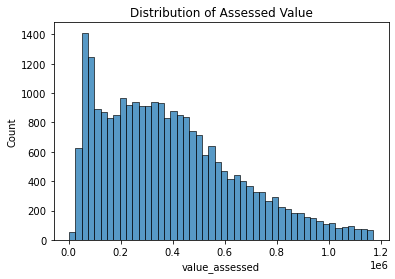

In [48]:
#taxvalue with outliers removed
sns.histplot(data=df.value_assessed)
plt.title('Distribution of Assessed Value')
plt.show()

<hr style="border:1px solid black"> </hr>

##### Dealing with Total Square Feet Outliers

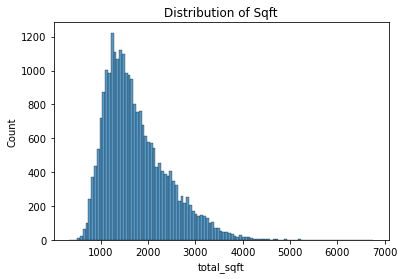

In [47]:
#sqft distribution
sns.histplot(data=df.total_sqft)
plt.title('Distribution of Sqft')
plt.show()

In [52]:
df.total_sqft.describe()

count    25142.000000
mean      1750.113197
std        668.999538
min        326.000000
25%       1253.250000
50%       1600.000000
75%       2118.000000
max       6756.000000
Name: total_sqft, dtype: float64

In [53]:
#finding IQR of Tax Value to find outliers
q1_sqft = df['total_sqft'].quantile(0.25)
q3_sqft = df['total_sqft'].quantile(0.75)
iqr_sqft = q3_sqft - q1_sqft

print(f'IQR for total square feet is: {iqr_sqft}')
print(f'Q3 for total square feet is: {q3_sqft}')
print(f'Q1 for total square feet is: {q1_sqft}')

IQR for total square feet is: 864.75
Q3 for total square feet is: 2118.0
Q1 for total square feet is: 1253.25


In [54]:
lowerbound_sqft = q1_sqft - (1.5 * iqr_sqft)
upperbound_sqft = q3_sqft + (1.5 * iqr_sqft)
print(f'Lower bounds for Square Feet  is: {lowerbound_sqft}')
print(f'Upper bounds for Square Feet is: {upperbound_sqft}')

Lower bounds for Square Feet  is: -43.875
Upper bounds for Square Feet is: 3415.125


In [55]:
#remove outliers for sqft
df= df[df.total_sqft > lowerbound_sqft]
df= df[df.total_sqft < upperbound_sqft]

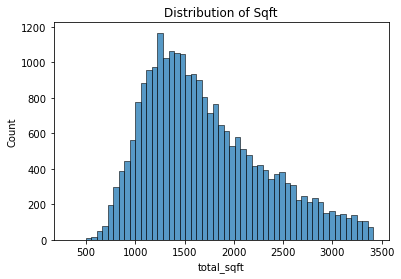

In [56]:
#sqft distribution with outliers removed
sns.histplot(data=df.total_sqft)
plt.title('Distribution of Sqft')
plt.show()

In [57]:
#we now have 24610 entries after dropping outliers in chosen columns
# 3,682 entries were dropped as outliers (13% dropped)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24610 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      24610 non-null  float64
 1   bedrooms        24610 non-null  float64
 2   bathrooms       24610 non-null  float64
 3   value_assessed  24610 non-null  float64
 4   tax_amount      24610 non-null  float64
 5   year_built      24610 non-null  float64
 6   county_code     24610 non-null  float64
 7   parcelid        24610 non-null  int64  
 8   tax_rate        24610 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.9 MB


### Takeaways for Outliers

- I have decided to drop the outliers from the total_sqft, bedrooms, bathrooms and value_assessed columns
    - Although I cannot verify that this data isn't accurate, I am choosing to leave it out of my data.

<br>

- 3,682 total entires were removed after dropping outliers

<br>

- **Bedrooms**: units with less than 1.5 bedrooms and more than 5.5 bedrooms were dropped
- **Bathrooms**: units with less than 0.5 bathrooms and more than 4.5 bedrooms were dropped
- **Appraised Value**: units with appraised value of less than -395,599.86 and an appraised value of more than 1,171,775.13 were dropped
- **Total Square feet**: units with total square feet of less than - 43.88 and more than 3,415 were dropped

<hr style="border:2px solid black"> </hr>

In [61]:
#split data using zillow_split function from prepare file
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.zillow_split(df, 'value_assessed')

train -> (13781, 9)
validate -> (5907, 9)
test -> (4922, 9)


In [63]:
#specify numeric columns that will be scaled
numeric_cols= ['total_sqft', 'year_built']

In [64]:
#scale the data using minmaxscaler function from prepare file
X_train_scaled, X_validate_scaled, X_test_scaled = prepare.min_max_scaler(X_train, X_validate, X_test, numeric_cols)

### Takeaways from Prepare 
- a column named tax_rate was created by dividing taxamount and taxvaluedollarcnt
- several columns were renamed in order to make them more legible
- duplicates and null values were dropped
- outliers were dropped from bedrooms, bathrooms, total_sqft and value_assessed columns
- final dataframe contains 24,610 entries with 9 columns that are all numeric data types (float64 & int64)

<hr style="border:3px solid black"> </hr>

# Explore

In [68]:
#set variable to correlation
zillow_correlation = train.corr()

In [69]:
#this shows that total_sqft is closely correlated to value_assessed
zillow_corr = zillow_correlation['value_assessed'].sort_values(ascending=False)
zillow_corr

value_assessed    1.000000
tax_amount        0.960258
total_sqft        0.453666
bathrooms         0.369707
year_built        0.227459
bedrooms          0.204167
county_code       0.124354
parcelid          0.076986
tax_rate         -0.175648
Name: value_assessed, dtype: float64

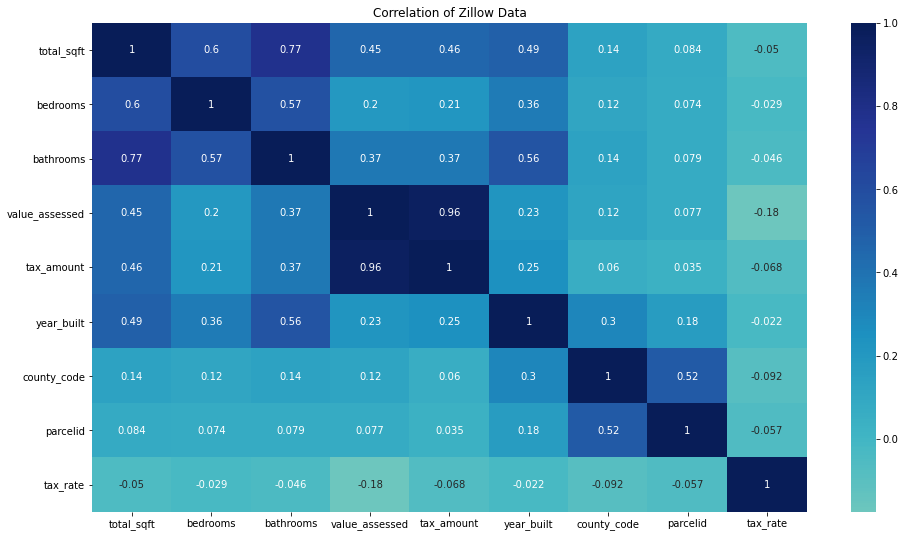

In [70]:
#heatmap to show correlation of all data
plt.figure(figsize=(16,9))

sns.heatmap(train.corr(), cmap='YlGnBu', center=0, annot=True)

plt.title('Correlation of Zillow Data')

plt.show()

### Feature Engineering

In [71]:
#RFE
lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=2)
rfe.fit_transform(X_train_scaled, y_train)
feature_mask_rank = rfe.ranking_
pd.Series(dict(zip(X_train.columns, rfe.ranking_))).sort_values()

total_sqft     1
tax_rate       1
bedrooms       2
bathrooms      3
year_built     4
county_code    5
tax_amount     6
parcelid       7
dtype: int64

In [72]:
#SelectKBest model 
f_selector = SelectKBest(score_func=f_regression, k=2)
#fit the model
f_selector.fit(X_train, y_train)
mask = f_selector.get_support()
X_train.columns[mask]

Index(['total_sqft', 'tax_amount'], dtype='object')

### Takeaways from Feature Engineering and Correlation:
- Although tax_amount has the highest correlation, I will not be using it to model. This would cause the model to have prior knowledge and result in inaccuaracies.
- RFE and SelectKBest show that total_sqft is the most important feature to use in predicting value_assessed

<hr style="border:2px solid black"> </hr>

### Hypothesis 1: T-Test (cont vs discrete)
$H_0$: There is no relationship between value_assessed and bedroom count
- value_assessed != bedroom count
<br>

$H_a$: There is a relationship between value_assessed and bedroom count
- value_assessed == bedroom count

In [89]:
#set alpha
alpha = .05

In [90]:
# sample size, must be more then 30 to meet assumption
train.value_assessed.count(), train.bedrooms.count()

(13781, 13781)

In [91]:
#check variance
train.value_assessed.var(), train.bedrooms.var()

#this shows not equal varient

(62595513701.88162, 0.6121007141677633)

In [92]:
#t-test on entire train set
t, p = stats.ttest_ind(train.value_assessed,train.bedrooms, equal_var=False)

In [93]:
t, p, alpha

(177.91120198112105, 0.0, 0.05)

In [94]:
p <alpha

True

In [95]:
print(f'We calculate a t of {t:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we fail to reject our null hypothesis')

We calculate a t of 177.911202 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we fail to reject our null hypothesis


<hr style="border:1px solid black"> </hr>

### Hypothesis 2: T-Test (cont vs discrete)
$H_0$: There is no relationship between value_assessed and number of bathrooms
- value_assessed != bathroom count
<br>

$H_a$: There is a relationship between value_assessed and number of bathrooms
- value_assessed == bathroom count

In [96]:
#set alpha
alpha = .05

In [97]:
# sample size, must be more then 30 to meet assumption
train.value_assessed.count(), train.bathrooms.count()

(13781, 13781)

In [98]:
#check variance
train.value_assessed.var(), train.bathrooms.var()

#this shows not equal varient

(62595513701.88162, 0.5141750900384159)

In [99]:
#t-test on entire train set
t, p = stats.ttest_ind(train.value_assessed,train.bathrooms, equal_var=False)

In [100]:
print(f'We calculate a t of {t:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we fail to reject our null hypothesis')

We calculate a t of 177.911715 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we fail to reject our null hypothesis


<hr style="border:1px solid black"> </hr>

### Hypothesis 3: Pearson's Correlation Test (cont vs cont)

$H_0$: There is no relationship between total_sqft and value_assessed
- total_sqft != value_assessed 
<br>

$H_a$: There is a relationship between total_sqft and value_assessed
- total_sqft == value_assessed

In [101]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

In [102]:
x= train.total_sqft
y= train.value_assessed

In [103]:
r, p = stats.pearsonr(x,y)

In [104]:
p < alpha

True

In [105]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.453666 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


<hr style="border:1px solid black"> </hr>

### Hypothesis 4: Pearson's Correlation Test (cont vs cont)

$H_0$: There is no relationship between tax_amount and value_assessed
- tax_amount != value_assessed 
<br>

$H_a$: There is a relationship between tax_amount and value_assessed
- tax_amount == value_assessed

In [106]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

In [107]:
x= train.tax_amount
y= train.value_assessed

In [108]:
r, p = stats.pearsonr(x,y)

In [109]:
p < alpha

True

In [110]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.960258 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


### Takeaways from Hypothesis Testing:
- **Hypothesis 1**: We reject the $H_0$. There is a relationship between the property's value assessed and the number of bedrooms
- **Hypothesis 2**: We reject the $H_0$. There is a relationship between the property's value assessed and the number of bathrooms
- **Hypothesis 3**: We reject the $H_0$. There is a relationship between the property's value assessed and the total square footage
- **Hypothesis 4**: We reject the $H_0$. There is a relationship between the property's value assessed and the tax amount

<hr style="border:px solid black"> </hr>

# Modeling

In [111]:
#take a look at X_train_scaled dataframe
#year_built and total_sqft are the only columns that are "scaled"
X_train_scaled.head()

,total_sqft,bedrooms,bathrooms,tax_amount,year_built,county_code,parcelid,tax_rate
11646,0.237617,3.0,1.0,2114.08,0.496183,6037.0,12475415,0.012821
3981,0.998381,3.0,3.0,9047.20,0.809160,6059.0,14498746,0.010243
20964,0.732923,3.0,3.0,4175.85,0.908397,6037.0,11215841,0.025229
11000,0.617028,4.0,3.0,2711.28,0.664122,6037.0,11187703,0.016116
11701,0.622208,4.0,3.0,6359.13,0.801527,6037.0,11345383,0.013420


In [112]:
#drop tax_amount from scaled data (too closely correlated, prior knowledge)
X_train_scaled = X_train_scaled.drop(columns=['tax_amount'])
X_validate_scaled = X_validate_scaled.drop(columns=['tax_amount'])
X_test_scaled = X_test_scaled.drop(columns=['tax_amount'])

In [113]:
#create a baseline
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [114]:
# 1. Predict assessed_value_pred_mean

#predicted mean will be the mean of value_assessed column
value_assessed_pred_mean = y_train['value_assessed'].mean()
#new column created
y_train['value_assessed_pred_mean'] = value_assessed_pred_mean
y_validate['value_assessed_pred_mean'] = value_assessed_pred_mean

In [115]:
y_train.head()

,value_assessed,value_assessed_pred_mean
11646,164898.0,379173.703723
3981,883229.0,379173.703723
20964,165519.0,379173.703723
11000,168238.0,379173.703723
11701,473844.0,379173.703723


In [116]:
# 2. RMSE of value_assessed_pred_mean

#root mean squared error of the predicted mean
rmse_train = mean_squared_error(y_train.value_assessed, y_train.value_assessed_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.value_assessed, y_validate.value_assessed_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  250181.88 
Validate/Out-of-Sample:  249144.58


In [117]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': rmse_train,
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.value_assessed, y_validate.value_assessed_pred_mean)}])

metric_df
#we now have out baseline model to work off of

,model,rmse_train,rmse_validate,r^2_validate
0,mean_baseline,250181.876924,249144.577291,0.0


<hr style="border:2px solid black"> </hr>

## Linear Regression Model

In [121]:
#take a look at all the columns in X_train_scaled
#from RFE and SelectKBest... we'll determine which columns to actually model
X_train_scaled.head()

,total_sqft,bedrooms,bathrooms,year_built,county_code,parcelid,tax_rate
11646,0.237617,3.0,1.0,0.496183,6037.0,12475415,0.012821
3981,0.998381,3.0,3.0,0.809160,6059.0,14498746,0.010243
20964,0.732923,3.0,3.0,0.908397,6037.0,11215841,0.025229
11000,0.617028,4.0,3.0,0.664122,6037.0,11187703,0.016116
11701,0.622208,4.0,3.0,0.801527,6037.0,11345383,0.013420


In [122]:
#set X_train_scaled to drivers only
#we do not want to include all columns in this because it could cause overfitting
drivers_train = X_train_scaled[['total_sqft', 'bedrooms', 'bathrooms']]

In [123]:
#set X_validate_scaled to drivers only
drivers_validate= X_validate_scaled[['total_sqft', 'bedrooms', 'bathrooms']]

In [124]:
#set X_test_scaled to drivers only
drivers_test= X_test_scaled[['total_sqft', 'bedrooms', 'bathrooms']]

In [125]:
#create the model 
lm = LinearRegression(normalize=True)

#fit
lm.fit(drivers_train, y_train.value_assessed)

LinearRegression(normalize=True)

In [126]:
# predict train
y_train['value_assessed_pred_lm'] = lm.predict(drivers_train)

In [127]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.value_assessed, y_train.value_assessed_pred_lm)**(1/2)

In [129]:
# predict validate
y_validate['value_assessed_pred_lm'] = lm.predict(drivers_validate)

In [130]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value_assessed, y_validate.value_assessed_pred_lm)**(1/2)

In [131]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  221563.06911626377 
Validation/Out-of-Sample:  220793.76494279603


In [132]:
#create visual to see baseline vs LinearRegression model
metric_df = metric_df.append(
    {
    'model': 'LinearRegression',
    'rmse_train': rmse_train,
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.value_assessed, y_validate.value_assessed_pred_lm)}, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate,r^2_validate
0,mean_baseline,250181.876924,249144.577291,0.000000
1,LinearRegression,221563.069116,220793.764943,0.214647


<hr style="border:2px solid black"> </hr>

## LassoLars Model

In [133]:
# create the model object
lars = LassoLars(alpha= 6)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(drivers_train, y_train.value_assessed)

# predict train
y_train['value_assessed_pred_lars'] = lars.predict(drivers_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value_assessed, y_train.value_assessed_pred_lars)**(1/2)

# predict validate
y_validate['value_assessed_pred_lars'] = lars.predict(drivers_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value_assessed, y_validate.value_assessed_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  221569.4107244009 
Validation/Out-of-Sample:  220802.94291882098


In [134]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 6',
    'rmse_train': rmse_train,
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.value_assessed, y_validate.value_assessed_pred_lars)}, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate,r^2_validate
0,mean_baseline,250181.876924,249144.577291,0.000000
1,LinearRegression,221563.069116,220793.764943,0.214647
2,LassoLars alpha 6,221569.410724,220802.942919,0.214582


<hr style="border:2px solid black"> </hr>

## Tweedie Regressor Model

In [135]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(drivers_train, y_train.value_assessed)

# predict train
y_train['value_assessed_pred_glm'] = glm.predict(drivers_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value_assessed, y_train.value_assessed_pred_glm)**(1/2)

# predict validate
y_validate['value_assessed_pred_glm'] = glm.predict(drivers_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value_assessed, y_validate.value_assessed_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  221538.88993310792 
Validation/Out-of-Sample:  220961.42308030082


In [136]:
#compares all four models
metric_df = metric_df.append(
    {
    'model': 'TweedieRegressor power 1',
    'rmse_train': rmse_train,
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.value_assessed, y_validate.value_assessed_pred_glm)}, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate,r^2_validate
0,mean_baseline,250181.876924,249144.577291,0.000000
1,LinearRegression,221563.069116,220793.764943,0.214647
2,LassoLars alpha 6,221569.410724,220802.942919,0.214582
3,TweedieRegressor power 1,221538.889933,220961.423080,0.213444


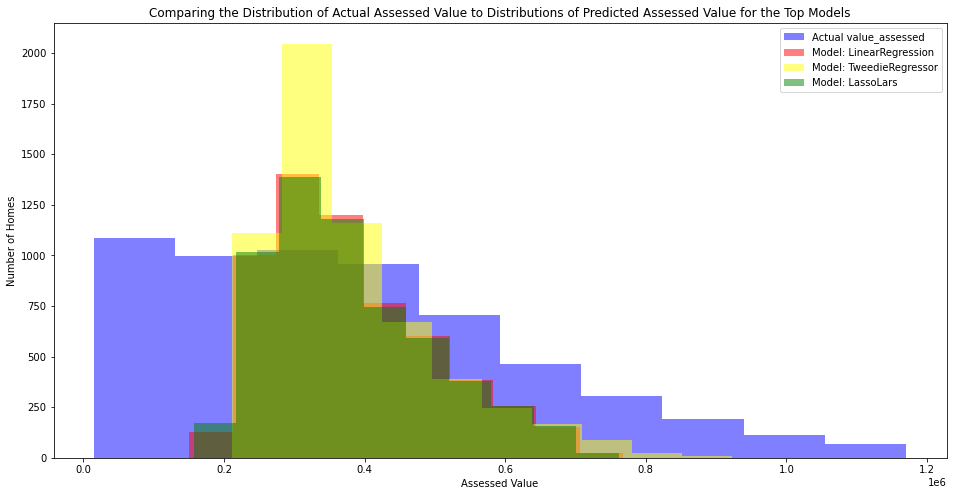

In [137]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.value_assessed, color='blue', alpha=.5, label="Actual value_assessed")
plt.hist(y_validate.value_assessed_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.value_assessed_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.value_assessed_pred_lars, color='green', alpha=.5, label="Model: LassoLars")
plt.xlabel("Assessed Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Assessed Value to Distributions of Predicted Assessed Value for the Top Models")
plt.legend()
plt.show()

### Use Test set on Best Performing Model

In [138]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['value_assessed_pred_lm'] = lm.predict(drivers_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.value_assessed, y_test.value_assessed_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  220334.2507070478


### Takeaways from Modeling:
- Linear Regression model performs better than the baseline and other predictive models

<hr style="border:2px solid black"> </hr>

## Tax_Rate per county

-graphs that shows distribution per county

In [ ]:
#this shows all the counties
df.county_code.unique()

In [ ]:
#number of homes per county
df['county_code'].value_counts()

In [ ]:
#plot tax rate by county
plt.figure(figsize=(14,10))
sns.histplot(data=df, x="tax_rate", hue="county_code", kde = False, bins = 750, palette = "Set2")

plt.title('Tax Rate by County')
plt.ylabel('Number of Homes')
plt.xlabel('Tax Rate')
plt.xlim(0, 0.035)
plt.show()

In [ ]:
df.head()

In [ ]:
#turn county code into a string
df['county_code'] = df['county_code'].astype(str)

#if county code has a 6 as the first number, create column called state and add california
df.loc[df['county_code'].str[0] == '6', 'state'] = 'California'

#if county code contrains 111, create column called county and add ventura
df.loc[df['county_code'].str.contains('111'), 'county'] = 'Ventura'

#if county code contrains 037, create column called county and add los angeles
df.loc[df['county_code'].str.contains('037'), 'county'] = 'Los Angeles'

#if county code contrains 059, create column called county and add orange
df.loc[df['county_code'].str.contains('059'), 'county'] = 'Orange'

#change dtype back to float
df['county_code'] = df['county_code'].astype(float)

In [ ]:
#make sure that state and county columns are created
df.head()

In [ ]:
df_rates_county = df[['parcelid', 'county_code', 'state', 'county', 'tax_rate']]

In [ ]:
df_rates_county.to_csv('rates_and_county.csv')

In [ ]:
# average tax rate PER county
average_tax_rate = df.groupby('county_code')['tax_rate'].mean()

In [ ]:
average_tax_rate.to_csv('average_tax_rate_by_county.csv')

In [ ]:
average_tax_rate